# トークトリアル１

# 化合物データの取得 (ChEMBL)

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Paula Junge and Svetlana Leng

## このトークトリアルの目的

ChEMBLからデータを抽出する方法の学習:

* ある特定の標的に対して評価済みのリガンドを見つける
* 取得可能な生理活性データでフィルタリング
* pIC50値の計算
* データフレームを結合し、取り出した分子を描画

## 学習の目標


### 理論

* ChEMBLデータベース
    * ChEMBL webサービス
    * ChEMBL webリソースクライアント
* 化合物の活性の評価
    * IC50
    * pIC50

### 実践
    
目標：与えられた標的に対する生理活性データのある化合物のリストを取得すること

* ChEMBLデータベースへの接続
* 標的（ターゲット分子）に関するデータの取得 (EGFR kinase)
* 生理活性データ
    * 生理活性をダウンロードしフィルタリングする
    * データの整型と変換
* 化合物データ
    * 化合物リストの取得
    * 出力データの準備
* 出力
    * 最もpIC50値の大きい分子を描画
    * アウトプットファイルの書き出し


## レファレンス

* ChEMBL生理活性データベース(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5210557/)
* ChEMBL Webサービス: <i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620 (https://academic.oup.com/nar/article/43/W1/W612/2467881) 
* ChEMBL Webリソースクライアント GitHub (https://github.com/chembl/chembl_webresource_client)
* myChEMBL Webサービス バージョン2.x (https://github.com/chembl/mychembl/blob/master/ipython_notebooks/09_myChEMBL_web_services.ipynb)
* ChEMBL Webインターフェース (https://www.ebi.ac.uk/chembl/)
* EBI-RDF プラットフォーム (https://www.ncbi.nlm.nih.gov/pubmed/24413672)
* IC50 と pIC50 (https://en.wikipedia.org/wiki/IC50)
* UniProt Webサイト (https://www.uniprot.org/)

_____________________________________________________________________________________________________________________


## 理論

### ChEMBLデータベース

* 大規模な生理活性の公開データベース
* **現在のデータ内容 (10.2018時点):**
    * 1.8 百万以上のユニークな構造の化合物
    * 1 百万アッセイに基づく 15 百万以上の活性値
    * ∼12 000 のターゲット分子に紐づけられたアッセイ
* **データソース** に含まれているもの：科学文献、PubChemバイオアッセイ、顧みられない病気のための創薬イニシアティブ(Drugs for Neglected Diseases Initiative (DNDi))、BindingDB データベース、などなど
* ChEMBLのデータは [Webインターフェース](https://www.ebi.ac.uk/chembl/)あるいは [EBI-RDFプラットフォーム](https://www.ncbi.nlm.nih.gov/pubmed/24413672) 、 [ChEMBL Webサービス](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/#B5)　からアクセスすることができます。
 
    
#### ChEMBL Webサービス

* RESTful webサービス
* ChEMBL webサービス バージョン 2.x リソーススキーマ: 

[![ChEMBL web service schema](images/chembl_webservices_schema_diagram.jpg)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/figure/F2/)

*Figure 1:* 
"ChEMBL webサービス スキーマダイアグラム。楕円型はChEMBL webサービスのリソースを示し、二つのリソースを繋ぐラインは、それらが共通の特徴を共有していることを示します。矢印の向きはリソースタイプについての一次情報を見つけられる場所を示しています。点線は２つのリソースの関係が異なる形式で振舞うことを示しています。例えば、`Image` リソースは `Molecule` のグラフィカルな描写を提供します。Figureと説明は次の文献からとりました: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881).


#### ChEMBL webリソースクライアント

* ChEMBLのデータにアクセスするためのPythonクライアントライブラリ
* HTTPSプロトコルとのやり取りを行う
* 結果の遅延評価（lazy evaluation） -> ネットワークリクエストを減らす

### 化合物活性評価

#### IC50 

* [50%阻害濃度（IC50、Half maximal inhibitory concentration)](https://en.wikipedia.org/wiki/IC50)
* ある生物学的なプロセスを半分阻害するのに必要な、ある特定の医薬品あるいは物質の量を示す値

[<img src="https://upload.wikimedia.org/wikipedia/commons/8/81/Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png" width="450" align="center" >](https://commons.wikimedia.org/wiki/File:Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png)

*Figure 2:* IC50値を算出する方法を視覚的に表した図:　阻害を縦軸、log(濃度)を横軸にデータを配置し、阻害の最大と最小を決定する。曲線が50%阻害レベルと交差する点の濃度がIC50

#### pIC50

* IC50値の比較を容易にするため、pIC50値をlogスケールで次のように定義しています <br />
    $ pIC_{50} = -log_{10}(IC_{50}) $  （$ IC_{50}$の単位はM）
* pIC50が大きくなるほど指数関数的に薬効が強くなっていることを示します
* pIC50はモル濃度の指標で与えられます (mol/L or M) <br />
    * IC50はM単位に換算したあとで、pIC50に変換する必要があります。  
    * nMの場合は: $pIC_{50} = -log_{10}(IC_{50}*10^{-9})= 9-log_{10}(IC_{50}) $
    
IC50と、pIC50に加えて、その他の生理活性の指標として、平衡定数 [KI](https://en.wikipedia.org/wiki/Equilibrium_constant) と50%効果濃度(half maximal effective concentration ([EC50](https://en.wikipedia.org/wiki/EC50) ))といったものが使われます。

## 実践

それでは、我々の興味のあるターゲット分子であるEGFRキナーゼに対して、評価が実施された全ての分子をダウンロードしたいと思います。

### ChEMBLデータベースへの接続

まず、ChEMBL webリソースクライアントと他のpythonライブラリーをインポートします。

In [1]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import math
from rdkit.Chem import PandasTools

**訳注(04.2020時点)**
```from chembl_webresource_client.new_client import new_client``` を実行すると以下のようなでエラーが出ました。
```
Exception: svg+xml is not an available format (['xml', 'json', 'yaml', 'svg'])
```
こちらの問題はclientのバージョンを上げることで解決できます。イシュー [#71](https://github.com/chembl/chembl_webresource_client/issues/71)を参照してください。アップデートは
```bash
pip install -U chembl-webresource-client
```
で実行可能でした。 「-U」を忘れずに！  
**訳注ここまで**

APIアクセスのためのリソースオブジェクトを作成します

In [2]:
targets = new_client.target
compounds = new_client.molecule
bioactivities = new_client.activity

## ターゲット分子のデータ

* UniProt Webサイト (https://www.uniprot.org/)　から目的とするターゲット分子（EGFRキナーゼ）の UniProt-ID (http://www.uniprot.org/uniprot/P00533) を取得します。
* UniProt-ID を使用してターゲット分子の情報を取得します。
* 他のターゲット分子に興味があるときは、ターゲットに合わせて異なるUniProt-IDを選択してください

In [6]:
uniprot_id = 'P00533'
# ChEMBLからターゲット分子の情報を取得しますが、
# 取得する項目を特定のものに絞って取得します。
target_P00533 = targets.get(target_components__accession=uniprot_id) \
                       .only('target_chembl_id', 'organism', 'pref_name', 'target_type')
print(type(target_P00533))
pd.DataFrame.from_records(target_P00533)

<class 'chembl_webresource_client.query_set.QuerySet'>


,cross_references,organism,pref_name,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'O43451', 'xref_name': None, 'xre...",Homo sapiens,Maltase-glucoamylase,False,CHEMBL2074,"[{'accession': 'O43451', 'component_descriptio...",SINGLE PROTEIN,9606.0
1,NaN,Homo sapiens,Epidermal growth factor receptor erbB1,NaN,CHEMBL203,NaN,SINGLE PROTEIN,NaN
2,NaN,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,NaN,CHEMBL2111431,NaN,PROTEIN FAMILY,NaN
3,NaN,Homo sapiens,Epidermal growth factor receptor,NaN,CHEMBL2363049,NaN,PROTEIN FAMILY,NaN
4,NaN,Homo sapiens,MER intracellular domain/EGFR extracellular do...,NaN,CHEMBL3137284,NaN,CHIMERIC PROTEIN,NaN


**訳注(0４.2020時点)**

出力したtypeはQuerySetとなっています。Django QuerySetインターフェースに基づいたデザインとなっているそうです。詳しくはchemble_webresource_clientの[GitHub](https://github.com/chembl/chembl_webresource_client)を参照してください
出力結果はオリジナルのJupyter Notebookと異なっています。

* ```only(~)``` で項目を絞っているはずですが、データフレームに表示された項目は絞られていません。  
* また、chembl_webresouce_clientの[`only`オペレーター](https://github.com/chembl/chembl_webresource_client/tree/46a5c9b264db7f91ea8c78fc4e71e9ca36f2870d#only-operator)の使用方法では引数をリストにすることが推奨されています。    
* index 0 のエントリーが「CHEMBL2074」 となっています。こちらはEGFRではなさそうです。エラーでしょうか？

参考までに、データの取得と絞り込みを２段階に分けた方法を下に示します。データフレームのカラムを選択しているだけです。

In [4]:
target_P00533 = targets.get(target_components__accession=uniprot_id) 
selected_target_values = ['organism', 'pref_name', 'target_chembl_id', 'target_type']
df_trarget_tmp = pd.DataFrame.from_records(target_P00533)[selected_target_values]
df_trarget_tmp

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Maltase-glucoamylase,CHEMBL2074,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN


**訳注ここまで**

### ヒットしたエントリーを確認したのち、最初のエントリーを目的のターゲット分子として選択
`CHEMBL203`: 単一のタンパク質（single protein）で human Epidermal growth factor receptor (EGFR, 別名 erbB1) を表しています。

In [7]:
target = target_P00533[0]
target

{'organism': 'Homo sapiens',
 'pref_name': 'Epidermal growth factor receptor erbB1',
 'target_chembl_id': 'CHEMBL203',
 'target_type': 'SINGLE PROTEIN'}

**訳注(0４.2020時点)**

DataFrameのindex 0 と同一の結果（「CHEMBL2074の出力」）となるかと思いましたが、オリジナルのGitHub のノートブック同様に「CHEMBL203」のが出力されました。QuerySetをDataFrameに変換するタイミングでエラーがあるのでしょうか？

**訳注ここまで**

選択したChEMBL-IDを保存します。

In [8]:
chembl_id = target['target_chembl_id']
chembl_id

'CHEMBL203'

### 生理活性データ

それでは、目的とするターゲット分子の生理活性データをクエリとして投げたいと思います。

#### ターゲット分子の生理活性をダウンロードしてフィルタリング

この工程では、生理活性データをダウンロードし、フィルターをかけます。次の項目のみ考慮します。

* ヒトタンパク質（human proteins）
* 生理活性タイプ（bioactivity type IC50）
* 精確な測定結果（関係式が '='　となっているもの)    
* 結合データ (アッセイタイプ 'B')

In [9]:
bioact = bioactivities.filter(target_chembl_id = chembl_id) \
                      .filter(type = 'IC50') \
                      .filter(relation = '=') \
                      .filter(assay_type = 'B') \
                      .only('activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
                            'molecule_chembl_id', 'type', 'units', 'relation', 'value', \
                            'target_chembl_id', 'target_organism')
# len(bioact), len(bioact[0]), type(bioact), type(bioact[0])
len(bioact[0]), type(bioact), type(bioact[0])

(43, chembl_webresource_client.query_set.QuerySet, dict)

**訳注(04.2020時点)**

`len(bioact)` はNonTypeのため表示できないといったエラーが出ました。コメントアウトし、残りの３つを表示させています。  
`len(bioact)` に相当するデータ（ヒットした化合物の数）は以降のDataFrame化、サイズ確認の段階で確認できます。

**訳注ここまで**

ChEMBLデータベースにクエリを投げるのが難しければ、先のセルのクエリの結果（11 April 2019）を含むファイルを提供しています。Pythonのパッケージ pickleを使いました。pickelはPythonのオブジェクトをシリアライズし、ファイルに保存、あとでプログラムに読み込めるようにします。（オブジェクトのシリアライズについて、さらに学びたいときには次を参照してください  [DataCamp](https://www.datacamp.com/community/tutorials/pickle-python-tutorial) )

pickle化した化合物を読み込むには次のセルのコメントアウトを外して実行してください。


In [10]:
#import pickle
#bioact = pickle.load(open("../data/T1/EGFR_compounds_from_chembl_query_20190411.p", "rb"))

#### 生理活性データを整型し変換する

データは辞書のリストととして保存されています。

In [11]:
bioact[0]

{'activity_comment': None,
 'activity_id': 31863,
 'activity_properties': [],
 'assay_chembl_id': 'CHEMBL663853',
 'assay_description': 'Inhibitory concentration against human DNA topoisomerase II, alpha mediated relaxation of pBR322; no measurable activity',
 'assay_type': 'B',
 'bao_endpoint': 'BAO_0000190',
 'bao_format': 'BAO_0000357',
 'bao_label': 'single protein format',
 'canonical_smiles': 'c1ccc(-c2nc3c(-c4nc5ccccc5o4)cccc3o2)cc1',
 'data_validity_comment': None,
 'data_validity_description': None,
 'document_chembl_id': 'CHEMBL1137930',
 'document_journal': 'Bioorg. Med. Chem. Lett.',
 'document_year': 2004,
 'ligand_efficiency': None,
 'molecule_chembl_id': 'CHEMBL113081',
 'molecule_pref_name': None,
 'parent_molecule_chembl_id': 'CHEMBL113081',
 'pchembl_value': None,
 'potential_duplicate': False,
 'qudt_units': 'http://www.openphacts.org/units/Nanomolar',
 'record_id': 206172,
 'relation': '>',
 'src_id': 1,
 'standard_flag': True,
 'standard_relation': '>',
 'standard_

PandasのDataFrameに変換します。（数分かかるかもしれません）

**訳注(04.2020時点)**  
上の出力でもクエリでのデータ取得の段階での項目の絞り込みがうまく機能していません。  
オリジナルのノートブックでは次に`pandas.DataFrame.from_records`によりDataFrameに変換していますが、項目数が多すぎるためかうまく変換できませんでした。  
そこで冗長ですが、以下のセルでは一度csvファイルに出力し、csvをDataFrameに読み込むという作業を行なっています。  
csv出力の段階で項目の絞り込みを実施ししています。（クエリの`only` の代替）。  
また、DataFrame変換後、項目の値の条件によるフィルタリングを念のため再度実施しています。  
**訳注ここまで**

In [19]:
import csv

# 出力したいフィールド （csvのheaderにする）
fields = ['activity_id','assay_chembl_id', 'assay_description', 'assay_type', 'molecule_chembl_id', 'type', 'units', 'relation', 'value', 'target_chembl_id', 'target_organism']

# bioact.csvというファイルを作成し出力する
with open('../data/T1/bioact.csv', 'w') as f:
    writer = csv.writer(f)
    
    # ヘッダーの書き込み
    writer.writerow(fields)
    
    # activityのデータを１行ずつ書き込み
    for act_data in bioact:
        row = []
        
        for field in fields:
            row.append(act_data[field])
        
        writer.writerow(row)

In [24]:
bioact_df_tmp = pd.read_csv('../data/T1/bioact.csv')

bioact_df = bioact_df_tmp.query('type == "IC50" and assay_type == "B" and relation == "="') # 条件に合致する行を残す
bioact_df.head(10)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,type,units,relation,value,target_chembl_id,target_organism
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,IC50,uM,=,0.041,CHEMBL203,Homo sapiens
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,IC50,uM,=,0.170,CHEMBL203,Homo sapiens
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,IC50,uM,=,9.300,CHEMBL203,Homo sapiens
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,IC50,uM,=,500.000,CHEMBL203,Homo sapiens
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,IC50,uM,=,3000.000,CHEMBL203,Homo sapiens
5,32780,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL77085,IC50,uM,=,96.000,CHEMBL203,Homo sapiens
6,33406,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL443268,IC50,uM,=,5.310,CHEMBL203,Homo sapiens
7,34039,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76979,IC50,uM,=,264.000,CHEMBL203,Homo sapiens
8,34041,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76589,IC50,uM,=,0.125,CHEMBL203,Homo sapiens
9,34049,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76904,IC50,uM,=,35.000,CHEMBL203,Homo sapiens


In [25]:
bioact_df.shape

(7177, 11)

欠損値のあるエントリーを削除します。

In [26]:
bioact_df = bioact_df.dropna(axis=0, how = 'any')
bioact_df.shape

(7176, 11)

重複を削除します。同じ化合物(`molecule_chembl_id`) について複数回の評価データが登録されていることが時々あります。今回は最初の結果だけを採用します。

In [27]:
bioact_df = bioact_df.drop_duplicates('molecule_chembl_id', keep = 'first')
bioact_df.shape

(5505, 11)

生理活性値がモル濃度の単位で評価されているものだけを残したいと思います。次のprint文は、どのような単位が含まれているかを確認し、行をいくつか削除したあとでどのようなエントリーが残すか調整するのに役立ちます。

In [28]:
print(bioact_df.units.unique())
bioact_df = bioact_df.drop(bioact_df.index[~bioact_df.units.str.contains('M')])
print(bioact_df.units.unique())
bioact_df.shape

['uM' 'nM' 'M' "10'1 ug/ml" 'ug ml-1' "10'-1microM" "10'1 uM"
 "10'-1 ug/ml" "10'-2 ug/ml" "10'2 uM" '/uM' "10'-6g/ml" 'mM' 'umol/L'
 'nmol/L']
['uM' 'nM' 'M' "10'-1microM" "10'1 uM" "10'2 uM" '/uM' 'mM']


(5435, 11)

**訳注(04.2020時点)**  
上のセルの条件 `~bioact_df.units.str.contains('M')`の`~`は`not`を意味します。  
pandasの条件では`and`、`or`、`not`の代わりに`&`、`|`、`~`を使うことでエラーを回避できるそうです。[参考](https://note.nkmk.me/python-numpy-pandas-value-error-ambiguous/)  
**訳注ここまで**

いくつか行を削除しましたが、あとでインデックスにしたがって反復処理（iteration）を行いたいので、インデックスを連続した値にリセットします。

In [31]:
bioact_df = bioact_df.reset_index(drop=True)  # drop=Trueで元の引数を削除
bioact_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,type,units,relation,value,target_chembl_id,target_organism
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,IC50,uM,=,0.041,CHEMBL203,Homo sapiens
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,IC50,uM,=,0.170,CHEMBL203,Homo sapiens
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,IC50,uM,=,9.300,CHEMBL203,Homo sapiens
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,IC50,uM,=,500.000,CHEMBL203,Homo sapiens
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,IC50,uM,=,3000.000,CHEMBL203,Homo sapiens


IC50値をさらに比較可能とするために、全ての単位をnMに変換します。まず、ヘルパー関数を書きます。この関数を次工程でデータフレーム全体に適用します。

In [32]:
def convert_to_NM(unit, bioactivity):
#     c=0
# for i, unit in enumerate(bioact_df.units):
    if unit != "nM":        
        if unit == "pM":
            value = float(bioactivity)/1000
        elif unit == "10'-11M":
            value = float(bioactivity)/100
        elif unit == "10'-10M":
            value = float(bioactivity)/10
        elif unit == "10'-8M":
            value = float(bioactivity)*10
        elif unit == "10'-1microM" or unit == "10'-7M":
            value = float(bioactivity)*100
        elif unit == "uM" or unit == "/uM" or unit == "10'-6M":
            value = float(bioactivity)*1000
        elif unit == "10'1 uM":
            value = float(bioactivity)*10000
        elif unit == "10'2 uM":
            value = float(bioactivity)*100000
        elif unit == "mM":
            value = float(bioactivity)*1000000
        elif unit == "M":
            value = float(bioactivity)*1000000000
        else:
            print ('unit not recognized...', unit)
        return value
    else: return bioactivity

In [33]:
bioactivity_nM = []
for i, row in bioact_df.iterrows():
    bioact_nM = convert_to_NM(row['units'], row['value'])
    bioactivity_nM.append(bioact_nM)
bioact_df['value'] = bioactivity_nM
bioact_df['units'] = 'nM'
bioact_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,type,units,relation,value,target_chembl_id,target_organism
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,IC50,nM,=,41.0,CHEMBL203,Homo sapiens
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,IC50,nM,=,170.0,CHEMBL203,Homo sapiens
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,IC50,nM,=,9300.0,CHEMBL203,Homo sapiens
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,IC50,nM,=,500000.0,CHEMBL203,Homo sapiens
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,IC50,nM,=,3000000.0,CHEMBL203,Homo sapiens


### 化合物データ

EGFRに対して評価を実施された全ての化合物（とそれぞれの評価方法）を含むデータフレームが手に入りました。それでは、それぞれのChEMBL IDの裏に隠れた化合物を取得したいと思います。

#### 化合物のリストを取得する

ChEMBLから抽出し生理活性データを明確にした化合物を見てみましょう。まず、望みの生理活性データを有する化合物のChEMBL IDと構造を取り出します。

In [34]:
cmpd_id_list = list(bioact_df['molecule_chembl_id'])
compound_list = compounds.filter(molecule_chembl_id__in = cmpd_id_list)\
                              .only('molecule_chembl_id','molecule_structures')

次に、リストをPandasのDataFrameに変換し、重複を削除します。（くどいですが、padas from_records　関数の実行は時間がかかるかもしれません）。

**訳注(04.2020時点)**

ここでもクエリのデータ取得の段階での項目の絞り込み(only)がうまく機能しておらず、DataFrameへの変換が非常に遅いので、csvの出力ののちDataFrameに変換するという方法をとりました。出力したcsvは17MBあり1時間弱かかりました。

**訳注ここまで**

In [38]:
# 出力したいフィールド （csvのheaderにする）
cmpd_fields = ['molecule_chembl_id','molecule_structures']

# cmpd.csvというファイルを作成し出力する
with open('../data/T1/cmpd.csv', 'w') as f:
    writer = csv.writer(f)
    
    # ヘッダーの書き込み
    writer.writerow(cmpd_fields)
    
    # activityのデータを１行ずつ書き込み
    for cmpd in compound_list:
        row = []
        
        for field in cmpd_fields:
            row.append(cmpd[field])
        
        writer.writerow(row)

In [115]:
# compound_df = pd.DataFrame.from_records(compound_list)
compound_df = pd.read_csv('../data/T1/cmpd.csv')
compound_df = compound_df.drop_duplicates('molecule_chembl_id', keep = 'first')
print(compound_df.shape)
print(bioact_df.shape)
compound_df.head()

(5435, 2)
(5435, 11)


,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...
2,CHEMBL6976,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncn(C)...
3,CHEMBL7002,{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3...
4,CHEMBL414013,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncnc(O...


この段階では、構造の情報について複数の異なる構造表現を保持しています。この中からカノニカルSMILESだけを残したいと思います。

**訳注（04.2020時点）**  
オリジナルの方法とは異なりcsvからDataFrameにしたことで、カラム「molecule_structures」の要素は見た目はdict型ですがstr型となっています。  
このままではcanonical_smilesをvalueとして取り出すことができません。  
以下では`ast`モジュールの`literal_eval`関数を適用してstr型からdict型に変換する処理を最初に実行しています。  
また、forループで処理する際の、欠損値行のスキップがもともとのif条件ではうまくいかなかったため、float型の場合スキップするという条件に変更しています。
**訳注ここまで**

In [116]:
# mapで型変換をデータフレーム全体に適用
# 欠損値でエラーが出るためmapの引数 na_actionを利用

import ast
compound_df['molecule_structures'] = compound_df['molecule_structures'].map(ast.literal_eval, na_action='ignore') 

In [118]:
for i, cmpd in compound_df.iterrows():
    # オリジナルのif条件
    # if compound_df.loc[i]['molecule_structures'] != None:
    
    if type(compound_df.loc[i]['molecule_structures']) != float: # Nanがfloat型であることを利用したif条件に書き換えた
        compound_df.loc[i]['molecule_structures'] = cmpd['molecule_structures']['canonical_smiles']

print (compound_df.shape)

(5435, 2)


#### 出力データの準備

知りたい値をChEMBL IDに基づいて一つのデータフレームに統合します。
* ChEMBL-IDs
* SMILES
* 単位
* IC50

In [119]:
output_df = pd.merge(bioact_df[['molecule_chembl_id','units','value']], compound_df, on='molecule_chembl_id')
print(output_df.shape)
output_df.head()

(5435, 4)


,molecule_chembl_id,units,value,molecule_structures
0,CHEMBL68920,nM,41.0,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CHEMBL69960,nM,170.0,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
2,CHEMBL137635,nM,9300.0,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12
3,CHEMBL306988,nM,500000.0,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,nM,3000000.0,O=C(O)/C=C/c1ccc(O)cc1


カラム（列）名を、それぞれIC50とSMILESに変更します。

In [121]:
output_df = output_df.rename(columns= {'molecule_structures':'smiles', 'value':'IC50'})
output_df.shape

(5435, 4)

SMILES表記が手に入らない化合物については、以降のトークトリアルで使用することができません。ですので、SMILES列に値のない化合物を削除します。

In [122]:
output_df = output_df[~output_df['smiles'].isnull()]
print(output_df.shape)
output_df.head()

(5428, 4)


,molecule_chembl_id,units,IC50,smiles
0,CHEMBL68920,nM,41.0,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CHEMBL69960,nM,170.0,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
2,CHEMBL137635,nM,9300.0,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12
3,CHEMBL306988,nM,500000.0,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,nM,3000000.0,O=C(O)/C=C/c1ccc(O)cc1


次のセルを実行すると、小さなIC50値が読みづらいことがわかると思います。そこで、IC50値をpIC50値に変換したいと思います。

In [123]:
output_df = output_df.reset_index(drop=True)
ic50 = output_df.IC50.astype(float) 
print(len(ic50))
print(ic50.head(10))

5428
0         41.0
1        170.0
2       9300.0
3     500000.0
4    3000000.0
5      96000.0
6       5310.0
7     264000.0
8        125.0
9      35000.0
Name: IC50, dtype: float64


In [124]:
# IC50をpIC50に変換し、pIC50の列を付け足す
pIC50 = pd.Series() 
i = 0
while i < len(output_df.IC50):
    value = 9 - math.log10(ic50[i]) # pIC50=-log10(IC50 mol/l) --> for nM: -log10(IC50*10**-9)= 9-log10(IC50)
    if value < 0:
        print("Negative pIC50 value at index"+str(i))
    pIC50.at[i] = value
    i += 1
    
output_df['pIC50'] = pIC50
output_df.head()

,molecule_chembl_id,units,IC50,smiles,pIC50
0,CHEMBL68920,nM,41.0,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,CHEMBL69960,nM,170.0,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,6.769551
2,CHEMBL137635,nM,9300.0,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
3,CHEMBL306988,nM,500000.0,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
4,CHEMBL66879,nM,3000000.0,O=C(O)/C=C/c1ccc(O)cc1,2.522879


### EGFRを標的として集めた生理活性データ

集めたデータセットを眺めてみましょう。

#### 化合物を描画する

次の工程ではデータフレームに化合物を追加し、もっとも大きいpIC50値をもつ化合物の構造を眺めます。

In [125]:
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol='smiles')

pIC50値で化合物をソートします。

In [126]:
output_df.sort_values(by="pIC50", ascending=False, inplace=True)
output_df.reset_index(drop=True, inplace=True)

もっとも活性な分子を、もっとも大きなpIC50値の分子として描画します。

,molecule_chembl_id,units,IC50,pIC50,ROMol
0,CHEMBL63786,nM,0.003,11.522879,
1,CHEMBL53711,nM,0.006,11.221849,
2,CHEMBL35820,nM,0.006,11.221849,
3,CHEMBL53753,nM,0.008,11.096910,
4,CHEMBL66031,nM,0.008,11.096910,

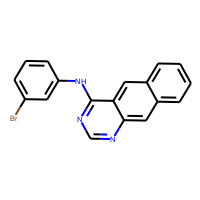
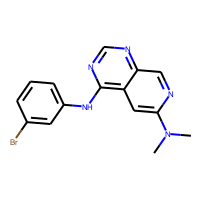
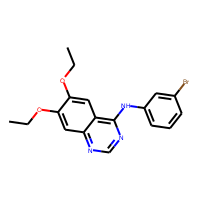
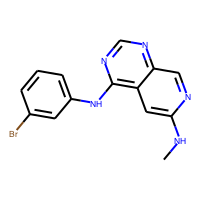
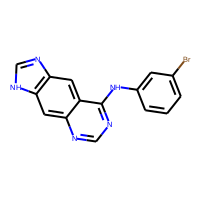

In [127]:
output_df.drop("smiles", axis=1).head()

**訳注(04.2020時点)**

ROMolに構造が描画されず、（SMILESでもない）文字列になっている場合はRDKitとPandasのバージョンの互換性がよくない可能性があります。Pandasを version 0.25.0 以前のものにすることで解決する可能性があります。 [RDKit イシュー](https://github.com/rdkit/rdkit/issues/2673)　を参照してください。

**訳注ここまで**

#### 出力ファイルの書き出し

以降のトークトリアルでデータを使うため、csvファイルとしてデータを保存します。データを保存するときには化合物の列（分子の構造図のみをもつ列）を削除することをお勧めします。

In [128]:
output_df.drop("ROMol", axis=1).to_csv("../data/T1/EGFR_compounds.csv")

## ディスカッション

このチュートリアルではChEMBLのデータベースから、私たちの目的とするターゲット分子に対して取得可能な全ての生理活性データを集めました。データセットをIC50あるいはpIC50の測定値をもつものだけにフィルタリングしました。

ChEMBLのデータはさまざまなデータソースに由来するものであることに注意してください。化合物のデータは世界中の様々なラボの様々な人々によって生み出されたものです。したがって、このデータセットを使って予測を行うときには注意する必要があります。結果を解釈し、自分たちの予測にどれだけの信頼を置けるか決める際には、データのソースとデータの生み出されたアッセイの一貫性について、常に慎重に考えることが重要です。

次のチュートリアルでは、手に入れたデータをリピンスキーのルールオブファイブでフィルタリングし、そして好ましくない部分構造でフィルタリングします。もう一つな他の重要なステップとして、データを綺麗に整型し、重複を取り除くことが挙げられます。（まだ、）私たちのトークトリアルでは取り上げられていないので、このタスクに使えるツールとして、標準化ライブラリ ([github Francis Atkinson](https://github.com/flatkinson/standardiser)) あるいは [MolVS](https://molvs.readthedocs.io/en/latest/) というものがあることに言及しておきたいと思います。

## クイズ

* このトークトリアルではChEMBLから化合物と生理活性データをダウンロードしました。ChEMBLデータベースは他にどのように利用することができるしょうか？
* IC50とEC50の違いは何でしょうか？
* ChEMBLから取り出したデータはどのような目的で使いことができるでしょうか？